In [96]:
import numpy as np 
import pandas as pd 

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression,ElasticNet, Lasso, Ridge
from DataTransformer import columnAdderTransformer,columnDropperTransformer
from sklearn.preprocessing import QuantileTransformer, quantile_transform
from sklearn.compose import TransformedTargetRegressor
from time import time

In [42]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [43]:
# Numeric features
numeric_features = [ item for item in train._get_numeric_data().columns.tolist() if item not in['Id','PID','SalePrice','Year Built', 'Year Remod/Add','Yr Sold']]
numeric_features = numeric_features + ['Years of Construction','Years of Remodel']

# Non ordinal categorical features
non_ordinal_categ = ['MS Zoning', 'Street', 'Lot Shape','Land Contour','Utilities',\
                     'Lot Config','Neighborhood','Bldg Type','House Style','Roof Style', 'Roof Matl',\
                     'Mas Vnr Type','Foundation','Heating','Electrical','Garage Type','Sale Type',\
                    'Condition 1','Condition 2','Exterior 1st','Exterior 2nd']

# Ordinal categorical features
ordinal_categ_features = ['Land Slope','Exter Qual','Exter Cond','Bsmt Qual','Bsmt Cond',\
                          'Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2','Heating QC','Central Air',\
                          'Kitchen Qual','Functional','Garage Finish','Garage Qual','Garage Cond','Paved Drive']

# Labels
Land_Slope =[['NA','Gtl', 'Mod', 'Sev']]
Exter_Qual = [['NA','Po', 'Fa','TA', 'Gd', 'Ex']]
Exter_Cond = [['NA','Po', 'Fa', 'TA', 'Gd', 'Ex']]
Bsmt_Qual = [['NA', 'Po', 'Fa','TA', 'Gd', 'Ex']]
Bsmt_Cond = [['NA', 'Po', 'Fa','TA', 'Gd', 'Ex']]
Bsmt_Exposure = [['NA', 'No', 'Mn', 'Av', 'Gd']]
BsmtFinType1 = [['NA', 'Unf', 'LwQ','Rec','BLQ','ALQ','GLQ']]
BsmtFinType2 = [['NA', 'Unf', 'LwQ','Rec','BLQ','ALQ','GLQ']]
Heating_QC = [['NA','Po', 'Fa', 'TA', 'Gd', 'Ex']]
Central_Air = [['NA','N','Y']]
Kitchen_Qual = [['NA','Po', 'Fa', 'TA', 'Gd', 'Ex']]
Functional = [['NA','Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ']]
Garage_Finish = [['NA','Unf','RFn','Fin']]
Garage_Qual = [['NA', 'Po', 'Fa','TA', 'Gd', 'Ex']]
Garage_Cond = [['NA', 'Po', 'Fa','TA', 'Gd', 'Ex']]
Paved_Drive = [['NA','N','P','Y']]

In [44]:
X = train.drop('SalePrice', axis=1)
y = train['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)


In [57]:
y_trans = y_trans = quantile_transform(
    y.to_frame(), n_quantiles=900, output_distribution="normal", copy=True
).squeeze()

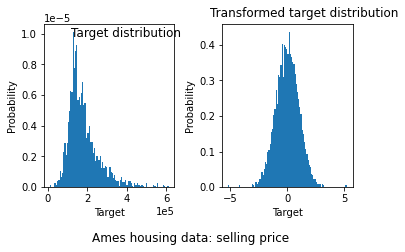

In [58]:

f, (ax0, ax1) = plt.subplots(1, 2)

ax0.hist(y, bins=100, density=True)
ax0.set_ylabel("Probability")
ax0.set_xlabel("Target")
ax0.text(s="Target distribution", x=1.2e5, y=9.8e-6, fontsize=12)
ax0.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))

ax1.hist(y_trans, bins=100, density=True)
ax1.set_ylabel("Probability")
ax1.set_xlabel("Target")
ax1.text(s="Transformed target distribution", x=-6.8, y=0.479, fontsize=12)

f.suptitle("Ames housing data: selling price", y=0.04)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])



In [46]:
col_transformer = Pipeline(steps=[ 
    ('Adder',columnAdderTransformer()),
    ('dropper',columnDropperTransformer(['Fireplace Qu','Fence','Alley','Misc Feature','Pool QC','Year Built', 'Year Remod/Add','Yr Sold']))
    ]) 


numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')) ]) 


categorical_features = non_ordinal_categ
categorical_transformer = Pipeline(steps=[ 
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), 
    ('onehot', OneHotEncoder(handle_unknown='ignore'))]) 

In [47]:
u = col_transformer.fit_transform(X,y)

# position dict for ordinal_categ_features
l_cols = {v:k for k,v in zip(range(len(u.columns)),u.columns)} 

ocpos =[]
for i in ordinal_categ_features:
    ocpos.append(l_cols[i])
    
# positions for ordinal category
ocpos

[11, 25, 26, 28, 29, 30, 31, 33, 38, 39, 51, 53, 57, 60, 61, 62]

In [48]:
preprocessor = ColumnTransformer( transformers=[ 
    ('o1',OrdinalEncoder(categories= Land_Slope,handle_unknown='use_encoded_value', unknown_value=-1), [11]),
    ('o2',OrdinalEncoder(categories= Exter_Qual,handle_unknown='use_encoded_value', unknown_value=-1), [25]),
    ('o3',OrdinalEncoder(categories= Exter_Cond,handle_unknown='use_encoded_value', unknown_value=-1), [26]),
    ('o4',OrdinalEncoder(categories= Bsmt_Qual,handle_unknown='use_encoded_value', unknown_value=-1), [28]),
    ('o5',OrdinalEncoder(categories= Bsmt_Cond,handle_unknown='use_encoded_value', unknown_value=-1), [29]),
    ('o6',OrdinalEncoder(categories= Bsmt_Exposure,handle_unknown='use_encoded_value', unknown_value=-1), [30]),
    ('o7',OrdinalEncoder(categories= BsmtFinType1,handle_unknown='use_encoded_value', unknown_value=-1), [31]),
    ('o8',OrdinalEncoder(categories= BsmtFinType2,handle_unknown='use_encoded_value', unknown_value=-1), [33]),
    ('o9',OrdinalEncoder(categories= Heating_QC,handle_unknown='use_encoded_value', unknown_value=-1), [38]),
    ('o10',OrdinalEncoder(categories= Central_Air,handle_unknown='use_encoded_value', unknown_value=-1), [39]),
    ('o11',OrdinalEncoder(categories= Kitchen_Qual,handle_unknown='use_encoded_value', unknown_value=-1), [51]),
    ('o12',OrdinalEncoder(categories= Functional,handle_unknown='use_encoded_value', unknown_value=-1), [53]),
    ('o13',OrdinalEncoder(categories= Garage_Finish,handle_unknown='use_encoded_value', unknown_value=-1), [57]),
    ('o14',OrdinalEncoder(categories= Garage_Qual,handle_unknown='use_encoded_value', unknown_value=-1), [60]),
    ('o15',OrdinalEncoder(categories= Garage_Cond,handle_unknown='use_encoded_value', unknown_value=-1), [61]),
    ('o16',OrdinalEncoder(categories= Paved_Drive,handle_unknown='use_encoded_value', unknown_value=-1), [62]), 
    ('num', numeric_transformer, numeric_features), 
    ('cat', categorical_transformer, categorical_features)])


In [49]:
pipeline = Pipeline(steps=[
                      ('transformer', col_transformer),
                      ('preprocessor', preprocessor),
                      ('scaler', RobustScaler()),
                      ('regressor', LinearRegression())
])


In [59]:
# Transform targets and use same linear model
regr_trans = TransformedTargetRegressor(
    regressor=pipeline, transformer=QuantileTransformer(n_quantiles=900, output_distribution="normal")
)
regr_trans.fit(X_train, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('transformer',
                                                      Pipeline(steps=[('Adder',
                                                                       columnAdderTransformer()),
                                                                      ('dropper',
                                                                       <DataTransformer.columnDropperTransformer object at 0x7fc4a1112310>)])),
                                                     ('preprocessor',
                                                      ColumnTransformer(transformers=[('o1',
                                                                                       OrdinalEncoder(categories=[['NA',
                                                                                                                   'Gtl',
                                                                                                                   'Mod',
                                                                                                                   'Sev']],
                                                                                                      handle_unknown='use_encoded_value',
                                                                                                      unknown_v...
                                                                                        'Neighborhood',
                                                                                        'Bldg '
                                                                                        'Type',
                                                                                        'House '
                                                                                        'Style',
                                                                                        'Roof '
                                                                                        'Style',
                                                                                        'Roof '
                                                                                        'Matl',
                                                                                        'Mas '
                                                                                        'Vnr '
                                                                                        'Type',
                                                                                        'Foundation',
                                                                                        'Heating',
                                                                                        'Electrical',
                                                                                        'Garage '
                                                                                        'Type',
                                                                                        'Sale '
                                                                                        'Type',
                                                                                        'Condition '
                                                                                        '1',
                                                                                        'Condition '
                                                                                        '2',
                                                                                        'Exterior '
                                                                                        '1st',
                                                                                        'Exterior '
                                                                                        '

In [61]:
print('Train score:',pipeline.score(X_train, y_train))
print('Test score:',pipeline.score(X_test,y_test))

print('Train score(log y):',regr_trans.score(X_train, y_train))
print('Test score(log y):',regr_trans.score(X_test,y_test))

Train score: 0.9171606677404956
Test score: 0.9146401169403724
Train score(log y): 0.9355796016054897
Test score(log y): 0.9337388567055822


Text(0.5, 0.04, 'Ames house actual selling price vs prediction ')

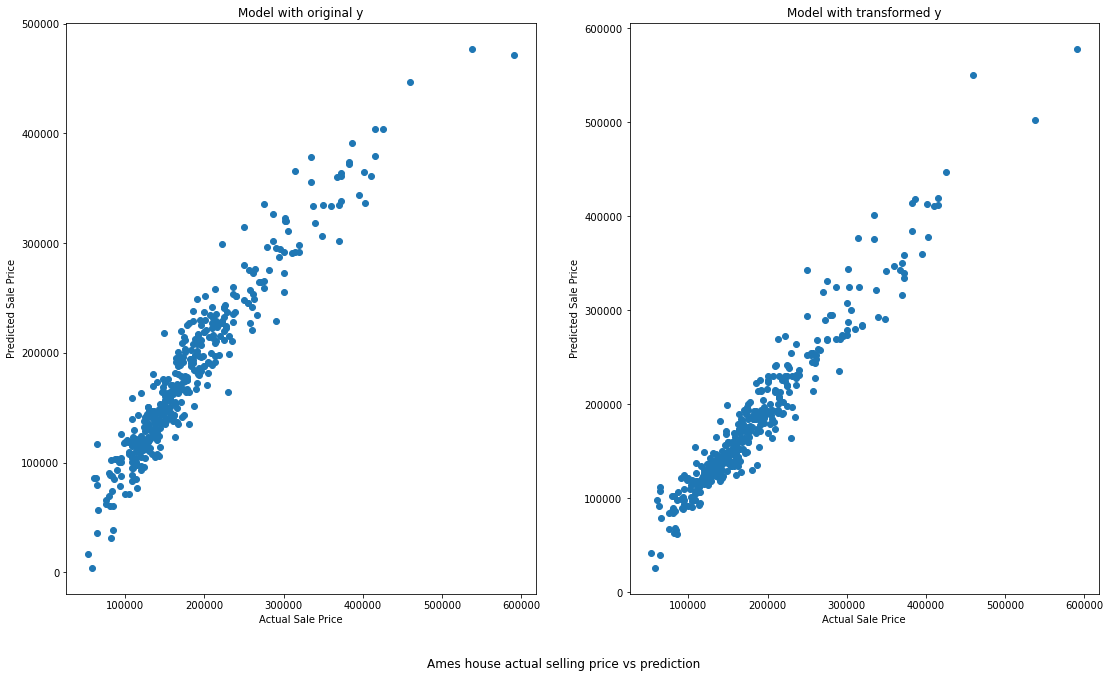

In [93]:
f, (ax0, ax1) = plt.subplots(1, 2)
f.set_size_inches(18.5, 10.5)
y1 = pipeline.predict(X_test)
y_pred = regr_trans.predict(X_test)

ax0.scatter(y_test,y_1)
ax0.set_ylabel("Predicted Sale Price")
ax0.set_xlabel("Actual Sale Price")
ax0.title.set_text(s="Model with original y" )


ax1.scatter(y_test,y_pred)
ax1.set_ylabel("Predicted Sale Price")
ax1.set_xlabel("Actual Sale Price")
ax1.title.set_text(s="Model with transformed y" )

f.suptitle("Ames house actual selling price vs prediction ", y=0.04)


In [100]:
mse_ = metrics.mean_squared_error(y_test, y1)
mse = metrics.mean_squared_error(y_test, y_pred)
#RSME
print('RMSE(origimal y):',np.sqrt(mse_))
print('RMSE(log y):',np.sqrt(mse))

RMSE(origimal y): 22891.757263934054
RMSE(log y): 20168.875678397082


### Findings: 
Transform y help to improve the model performance! After transformation, y is not reight skewed

In [76]:
pipeline_0 = Pipeline(steps=[
                      ('transformer', col_transformer),
                      ('preprocessor', preprocessor),
                      ('scaler', RobustScaler()),
                      ('EN',ElasticNet())
])

Model_0 = TransformedTargetRegressor(
    regressor = pipeline_0, transformer = QuantileTransformer(n_quantiles=900, output_distribution="normal")
)

params0 = { 'regressor__EN__alpha':[0.25,0.4,0.5,1.5,3,6],
            'regressor__EN__l1_ratio':[0.05,0.2,0.5,0.75,1.0]}
                
t0 = time()
print("Fitting started...")
search0 = RandomizedSearchCV(Model_0, param_distributions=params0, verbose=1)
search0.fit(X_train,y_train)
print(f"Fitting took {time() - t0:0.3f}s.")

Fitting started...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting took 5.024s.


In [104]:
print('Model_0 Score:')
print('Best CV score:',search0.best_score_)
print('Best Model parameters:',search0.best_params_)
print('Test score:',search0.score(X_test,y_test))
mse0 = metrics.mean_squared_error(y_test, search0.predict(X_test))
#RSME
print('RMSE:',np.sqrt(mse0))

Model_0 Score:
Best CV score: 0.8327184318325216
Best Model parameters: {'regressor__EN__l1_ratio': 0.05, 'regressor__EN__alpha': 0.4}
Test score: 0.9034717006384425
RMSE: 24343.30575172937


In [79]:
pipeline_1 = Pipeline(steps=[
                      ('transformer', col_transformer),
                      ('preprocessor', preprocessor),
                      ('scaler', RobustScaler()),
                      ('poly',PolynomialFeatures()),
                      ('EN',ElasticNet())
])

Model_1 = TransformedTargetRegressor(
    regressor = pipeline_1, transformer = QuantileTransformer(n_quantiles=900, output_distribution="normal")
)

paramsPolyEN = {'regressor__poly__degree':[1,2],
                'regressor__EN__alpha':[0.25,0.5,1.5,3,5],
                'regressor__EN__l1_ratio':[0.25,0.5,0.75,1.0]}
                
t0 = time()
print("Fitting started...")
search1 = RandomizedSearchCV(Model_1, param_distributions=paramsPolyEN, verbose=1)
search1.fit(X_train,y_train)
print(f"Fitting took {time() - t0:0.3f}s.")

Fitting started...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.132e+02, tolerance: 1.360e-01
  model = cd_fast.enet_coordinate_descent(
/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.180e+02, tolerance: 1.351e-01
  model = cd_fast.enet_coordinate_descent(
/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting took 213.562s.


In [105]:
print('Model_1 Score:')
print('Best CV score:',search1.best_score_)
print('Best Model parameters:',search1.best_params_)
print('Test score:',search1.score(X_test,y_test))
mse1 = metrics.mean_squared_error(y_test, search1.predict(X_test))
#RSME
print('RMSE:',np.sqrt(mse1))

Model_1 Score:
Best CV score: 0.628804317927231
Best Model parameters: {'regressor__poly__degree': 1, 'regressor__EN__l1_ratio': 0.75, 'regressor__EN__alpha': 0.25}
Test score: 0.7183968979202998
RMSE: 41578.70355918161


In [81]:
pipeline_2 = Pipeline(steps=[
                      ('transformer', col_transformer),
                      ('preprocessor', preprocessor),
                      ('scaler', RobustScaler()),
                      ('poly',PolynomialFeatures()),
                      ('ls',Lasso())
])

Model_2 = TransformedTargetRegressor(
    regressor = pipeline_2, transformer = QuantileTransformer(n_quantiles=900, output_distribution="normal")
)

paramsPolyls = {'regressor__poly__degree':[1,2],
                'regressor__ls__alpha':[0.1,0.5,1.5,3,5,7,15]}
                
t0 = time()
print("Fitting started...")
search2 = RandomizedSearchCV(Model_2, param_distributions=paramsPolyls, verbose=0)
search2.fit(X_train,y_train)
print(f"Fitting took {time() - t0:0.3f}s.")

Fitting started...


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.534e+02, tolerance: 1.360e-01
  model = cd_fast.enet_coordinate_descent(
/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.554e+02, tolerance: 1.356e-01
  model = cd_fast.enet_coordinate_descent(
/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting took 164.161s.


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.823e+02, tolerance: 1.356e-01
  model = cd_fast.enet_coordinate_descent(


In [106]:
print('Model_2 Score:')
print('Best CV score:',search2.best_score_)
print('Best Model parameters:',search2.best_params_)
print('Test score:',search2.score(X_test,y_test))
mse2 = metrics.mean_squared_error(y_test, search1.predict(X_test))
#RSME
print('RMSE:',np.sqrt(mse2))

Model_2 Score:
Best CV score: 0.7736472930166587
Best Model parameters: {'regressor__poly__degree': 1, 'regressor__ls__alpha': 0.1}
Test score: 0.860522254248327
RMSE: 41578.70355918161


In [94]:
pipeline_3 = Pipeline(steps=[
                      ('transformer', col_transformer),
                      ('preprocessor', preprocessor),
                      ('scaler', RobustScaler()),
                      ('poly',PolynomialFeatures()),
                      ('rg',Ridge())
])

Model_3 = TransformedTargetRegressor(
    regressor = pipeline_3, transformer = QuantileTransformer(n_quantiles=900, output_distribution="normal")
)

paramsPolyrg = {'regressor__poly__degree':[1,2],
                'regressor__rg__alpha':[0.25,0.5,1.5,3,5,10]}
                
t0 = time()
print("Fitting started...")
search3 = RandomizedSearchCV(Model_3, param_distributions=paramsPolyrg, verbose=0)
search3.fit(X_train,y_train)
print(f"Fitting took {time() - t0:0.3f}s.")

Fitting started...


/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.88325e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=5.76789e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=7.10092e-20): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=2.82748e-19): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=Fal

Fitting took 29.891s.


In [107]:
print('Model_3 Score:')
print('Best CV score:',search3.best_score_)
print('Best Model parameters:',search3.best_params_)
print('Test score:',search3.score(X_test,y_test))
mse3 = metrics.mean_squared_error(y_test, search1.predict(X_test))
#RSME
print('RMSE:',np.sqrt(mse3))

Model_3 Score:
Best CV score: 0.8685943405197539
Best Model parameters: {'regressor__rg__alpha': 10, 'regressor__poly__degree': 1}
Test score: 0.9305081822507675
RMSE: 41578.70355918161


## Conclusion

After comparing a few models, I found the linear model which has y transformed and without any feature selection or regularization performs the best

In [111]:
names = regr_trans.regressor.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()
for i in range(1,18):
    names = np.concatenate([names, pipeline.named_steps['preprocessor'].transformers_[i][1].get_feature_names_out()])

len(names)

209

In [112]:
trsf = Pipeline(steps=[
                      ('transformer', col_transformer),
                      ('preprocessor', preprocessor),])
df = trsf.transform(X_train)
print(df)

[[1. 4. 3. ... 0. 0. 1.]
 [1. 3. 3. ... 0. 1. 0.]
 [1. 3. 3. ... 0. 0. 0.]
 ...
 [1. 3. 3. ... 1. 0. 0.]
 [1. 4. 3. ... 1. 0. 0.]
 [1. 4. 3. ... 1. 0. 0.]]


In [113]:
## specify feature names as columns
all_features = pd.DataFrame(df, columns=names)
all_features.head()

,Land Slope,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating QC,Central Air,Kitchen Qual,Functional,Garage Finish,Garage Qual,Garage Cond,Paved Drive,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Years of Construction,Years of Remodel,MS Zoning_A (agr),MS Zoning_C (all),MS Zoning_FV,MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Street_Grvl,Street_Pave,Lot Shape_IR1,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Utilities_AllPub,Utilities_NoSeWa,Lot Config_Corner,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Bldg Type_1Fam,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,House Style_1.5Fin,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Roof Style_Flat,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed,Roof Matl_ClyTile,Roof Matl_CompShg,Roof Matl_Membran,Roof Matl_Tar&Grv,Roof Matl_WdShake,Roof Matl_WdShngl,Mas Vnr Type_BrkCmn,Mas Vnr Type_BrkFace,Mas Vnr Type_None,Mas Vnr Type_Stone,Mas Vnr Type_missing,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Garage Type_2Types,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Type_missing,Sale Type_COD,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD,Condition 1_Artery,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Artery,Condition 2_Feedr,Condition 2_Norm,Condition 2_PosA,Condition 2_PosN,Condition 2_RRAe,Condition 2_RRNn,Exterior 1st_AsbShng,Exterior 1st_BrkComm,Exterior 1st_BrkFace,Exterior 1st_CBlock,Exterior 1st_CemntBd,Exterior 1st_HdBoard,Exterior 1st_ImStucc,Exterior 1st_MetalSd,Exterior 1st_Plywood,Exterior 1st_Stone,Exterior 1st_Stucco,Exterior 1st_VinylSd,Exterior 1st_Wd Sdng,Exterior 1st_WdShing,Exterior 2nd_AsbShng,Exterior 2nd_AsphShn,Exterior 2nd_Brk Cmn,Exterior 2nd_BrkFace,Exterior 2nd_CBlock,Exterior 2nd_CmentBd,Exterior 2nd_HdBoard,Exterior 2nd_ImStucc,Exterior 2nd_MetalSd,Exterior 2nd_Plywood,Exterior 2nd_Stone,Exterior 2nd_Stucco,Exterior 2nd_VinylSd,Exterior 2nd_Wd Sdng,Exterior 2nd_Wd Shng
0,1.0,4.0,3.0,5.0,3.0,4.0,6.0,1.0,3.0,2.0,3.0,8.0,2.0,3.0,3.0,3.0,85.0,68.0,9927.0,7.0,5.0,252.0,1005.0,0.0,42.0,1047.0,1083.0,0.0,0.0,1083.0,1.0,0.0,1.0,0.0,2.0,1.0,5.0,1.0,1976.0,2.0,596.0,444.0,0.0,40.0,0.0,0.0,0.0,0.0,7.0,30.0,30.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.

In [114]:
coefs = pipeline.named_steps["regressor"].coef_.flatten()
coef = pd.DataFrame(zip(all_features.columns, coefs), columns=["feature", "coef"])
coef.sort_values(by='coef',ascending=False)

,feature,coef
123,Roof Matl_Membran,128212.528446
25,Total Bsmt SF,121815.082053
84,Neighborhood_GrnHill,119853.692271
126,Roof Matl_WdShngl,109713.014651
124,Roof Matl_Tar&Grv,85595.229080
125,Roof Matl_WdShake,80278.993220
178,Condition 2_RRAe,73765.452123
122,Roof Matl_CompShg,67088.550652
183,Exterior 1st_CBlock,45613.817467
157,Sale Type_Con,36012.427043


## Result
Find Top 5 features with largest coefficient. (for log transformed model)

In [115]:
coef['coef']=coef['coef'].abs()
coef = coef.sort_values(by='coef',ascending=False)
coef.iloc[:5,]

,feature,coef
121,Roof Matl_ClyTile,470888.316050
22,BsmtFin SF 1,143526.197755
123,Roof Matl_Membran,128212.528446
24,Bsmt Unf SF,126539.391792
25,Total Bsmt SF,121815.082053


## Output

In [116]:
saleprice = pipe.predict(test)
test['SalePrice'] = saleprice
res = test[['Id','SalePrice']]
#res
res.to_csv('/Users/zhangzhexu/Desktop/proj 2/output.csv', index=False)